### Step (1): Setup the environment

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D

-------------
### Step (2): Loading & Visualizing the data set
Before we can start determing the best **`k`**, let's load in the *`edlich_kmeans`* data set first:

In [2]:
edlich_kmeans = pd.read_csv('edlich-kmeans-A0.csv')
print('edlich_kmeans data shape: ', edlich_kmeans.shape)

edlich_kmeans data shape:  (100, 3)


Now, that we know the data set's bounds, lets examine of what columns it consists of:

In [3]:
edlich_kmeans.columns

Index(['V1', 'V2', 'V3'], dtype='object')

In [4]:
v1 = edlich_kmeans.V1.values
v2 = edlich_kmeans.V2.values
v3 = edlich_kmeans.V3.values

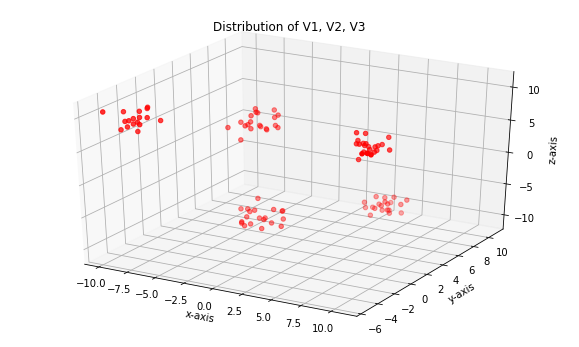

In [5]:
fig = plot.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Distribution of V1, V2, V3')
ax.scatter(v1, v2, v3, color='r', marker='o')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.grid(color='k', linestyle='-', linewidth=2)
plot.show()

------------
### Step(3): Determining the best `k`
The 3D-plot above shows the distribution of V1, V2, V3 and indicates that there might be **`5 clusters`** possible.<br />
But to be absolutely sure let's determining the k by using the `Elbow Method`.<br />
To do so, we are going to calculate cluster samples from a range between `k=1` and a `k=fourth of the whole data set`, which means between `K = [1;25]`. For each of those clusters we will sum the distances for all points around it's cluster centers which we will call `distortion` at this point:

In [6]:
distortions = []
k_range = range(1, 25)
X = edlich_kmeans.values

for k in k_range:
    # create and fit a k-mean model based on the current k
    clusters = KMeans(n_clusters=k).fit(X)
    clusters.fit(X)
    # calculate the distances to each k-mean cluster center point
    distortions.append(
        sum(
            np.min(cdist(X, clusters.cluster_centers_, 'euclidean'), axis=1)
        ) / X.shape[0]
    )

The summary of this calculation is shown by the followign table (*extract of the first ten calculations*), which sets the number of clusters in relation to it's total distorion:

In [7]:
summary = pd.DataFrame(
    {
        'number of k clusters': k_range,
        "distortion": distortions
    }
)
summary[0:10]

,number of k clusters,distortion
0,1,9.703835
1,2,6.609047
2,3,4.559829
3,4,2.985670
4,5,1.674812
5,6,1.347731
6,7,1.268785
7,8,1.206746
8,9,1.142794
9,10,1.106845


This summary table shows, that a `k` around **`6`** will match our needs for a low distorion of the data points around it's cluster center point - nerly the optimum as assumed from the initial data visualization.<br />
Hence, we will stay for a `k=6`, because all further increases of `k` won't shrink the distorion level tremendously.<br />
The following diagram, showing the *elbow curve* also enforces this:

Text(0.5,1,'The Elbow Method showing the optimal k')

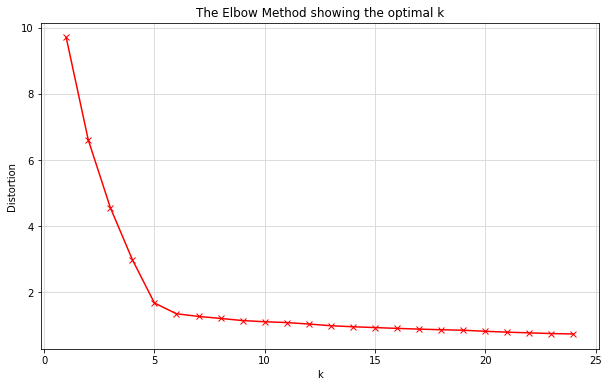

In [8]:
fig = plot.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid(color='gainsboro', linestyle='-', linewidth=1)
ax.plot(k_range, distortions, 'rx-')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
ax.set_title('The Elbow Method showing the optimal k')

#### ==> Hence, the optimum is found as k=6

-------------
### Step (4): Perform the clustering with k=6

Now, let's build the clusters for `k=6` and print the center points from each cluster:

In [9]:
k = 6
clusters = KMeans(n_clusters=k).fit(X)
center_points = clusters.cluster_centers_
center_points

array([[-5.10691526,  5.60179825,  3.71956936],
       [ 5.8824053 ,  3.59073875,  4.60507998],
       [-2.40331671,  2.14752865, -8.02378894],
       [-8.53242046, -3.55401526,  8.96857685],
       [ 3.66536804,  8.91074968, -9.06579829],
       [10.39919728, -3.2040623 ,  9.16365006]])

Next, wen want to determine all points which belong to a specific cluster now.<br />
For this purpose, we will define a so called `cluster map` which will map the cluster labels (the cluster index in this case) to the index table from the original data set.<br /><br />
We also need to define a function which filters all points corresponding to a specific cluster label from this defined `cluster map`:

In [10]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = edlich_kmeans.index.values
cluster_map['cluster'] = clusters.labels_


def get_cluster_values(cluster_label: int, data: np.ndarray) -> np.ndarray:
    index_list = cluster_map[cluster_map.cluster == cluster_label]['data_index']
    return data[index_list.values]

With this `cluster map` and the `get_cluster_values` function in place, we can go ahead and determine the cluster vectors:

In [11]:
for i in range(0, k):
    print('Cluster %d:\n' % (i+1), get_cluster_values(i, X), '\n\n')

Cluster 1:
 [[-5.34023562  4.7472463   3.82332607]
 [-5.1795348   4.8463202   4.24721594]
 [-4.42847662  6.65686938  4.00895955]
 [-4.91662608  4.52706291  3.45985437]
 [-5.18575661  7.62838338  4.34873261]
 [-4.54014196  5.81301663  2.73461296]
 [-5.97263413  6.72957119  4.24406454]
 [-3.69297625  6.04912323  3.02088667]
 [-4.36500448  6.98047231  4.1903933 ]
 [-5.21582739  4.25852428  3.9901113 ]
 [-5.05417849  5.7403774   3.1689619 ]
 [-4.26072049  6.51773545  2.9000841 ]
 [-5.45865171  4.05727103  1.87396836]
 [-4.85801617  6.29138331  2.18874797]
 [-5.27339307  5.03545157  5.04408956]
 [-6.16591621  3.53160768  3.91398691]
 [-6.04540195  6.55468387  4.9595981 ]
 [-6.15178543  4.99771439  3.81938746]
 [-5.15451901  5.97651538  2.79462218]
 [-4.87850882  5.0966352   5.65978342]] 


Cluster 2:
 [[5.7082258  2.65857479 5.40448245]
 [6.37219562 4.45994039 4.36935755]
 [5.62156138 3.43105644 4.66657363]
 [4.94946903 3.57706667 5.14013488]
 [5.28934395 2.90515625 6.83857031]
 [7.65107352

We can also visualize those cluster vectors.<br />
For simplicity we will visualize all clusters just within the 2D-space first:

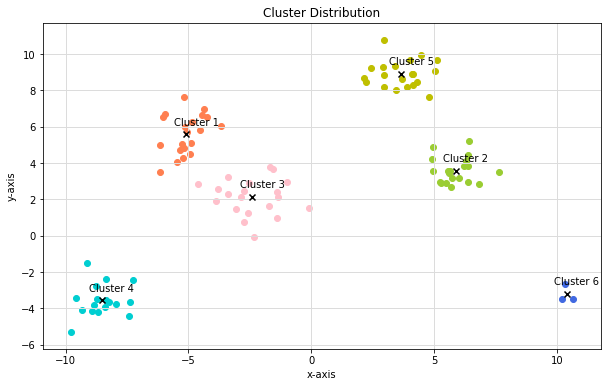

In [12]:
cluster_colors = [
    'coral', 
    'yellowgreen', 
    'pink', 
    'darkturquoise', 
    'y', 
    'royalblue'
] 

fig = plot.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title('Cluster Distribution')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.grid(color='gainsboro', linestyle='-', linewidth=1)

for i in range(0, k):
    p = center_points[i]
    cluster_points = get_cluster_values(i, X)
    # draw the clusters' center points
    ax.scatter(
        p[0], 
        p[1],
        color='k', marker='x', linewidths=5, zorder=10
    )
    # draw the cluster's points
    ax.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        color=cluster_colors[i], marker='o'
    )
    ax.annotate('Cluster %d' % (i+1), (p[0]-0.5, p[1]+0.5))

In the 3D-space, the distribution of all points across the created clusters would look like shown in the following diagram:

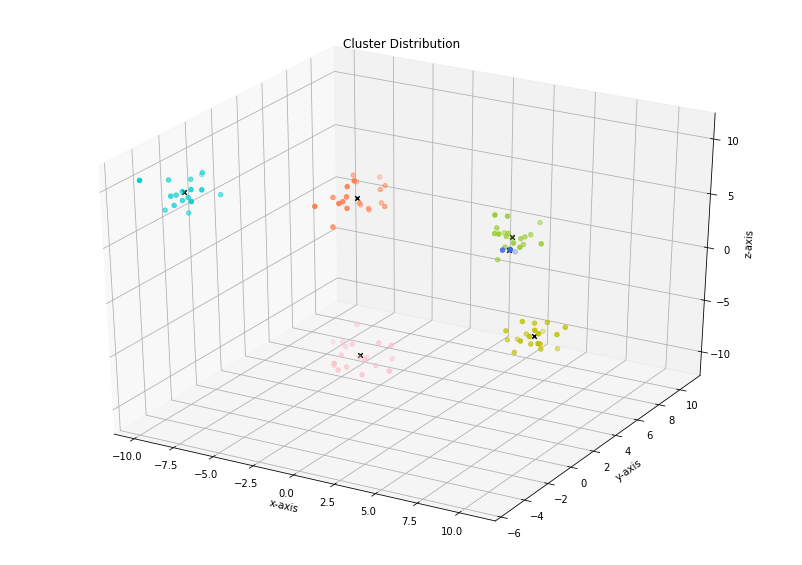

In [13]:
fig = plot.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Cluster Distribution')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
for i in range(0, k):
    p = center_points[i]
    cluster_points = get_cluster_values(i, X)
    # draw the clusters' center points
    ax.scatter(
        p[0], 
        p[1],
        p[2],
        color='k', marker='x', linewidths=5, zorder=10
    )
    # draw the cluster's points
    ax.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        cluster_points[:, 2],
        color=cluster_colors[i], marker='o'
    )